In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Attention, TimeDistributed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [2]:
df = pd.read_csv('/content/AMZN.csv', index_col='Date', parse_dates=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5665 entries, 1997-05-15 to 2019-11-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5665 non-null   float64
 1   High       5665 non-null   float64
 2   Low        5665 non-null   float64
 3   Close      5665 non-null   float64
 4   Adj Close  5665 non-null   float64
 5   Volume     5665 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 309.8 KB


In [4]:
df = df.drop(['Low', 'Adj Close', 'Volume','Open'], axis=1)

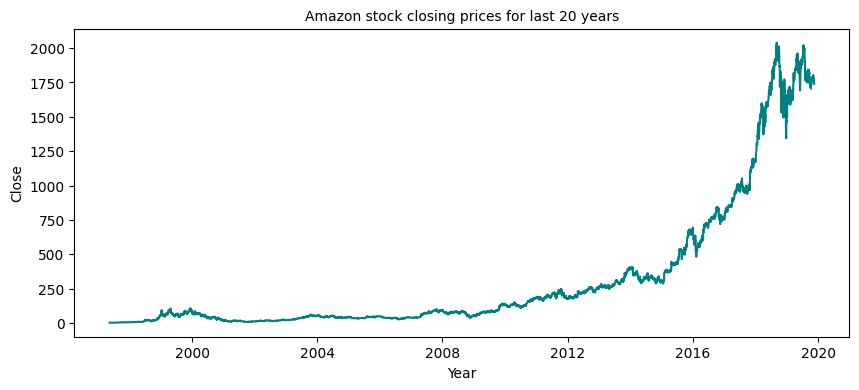

In [5]:
plt.figure(figsize=(10, 4))
plt.title('Amazon stock closing prices for last 20 years', fontsize=10)
sns.lineplot(df.Close, color='teal')
plt.xlabel('Year')
plt.show()

## Spliting Training And Testing Data

In [6]:
train_set = df[:'2016'].iloc[:,1:2].values
test_set = df['2017':].iloc[:,1:2].values

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
train_set = scaler.fit_transform(train_set)

In [8]:
X_train = []
y_train = []
for i in range(60,4941):
    X_train.append(train_set[i-60:i,0])
    y_train.append(train_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

## Using RNN to predict closing prices

In [34]:
model = Sequential()

# adding LSTM layers
model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, activation='relu'))
model.add(Dropout(0.2))

# adding dense layers
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 60, 64)            16896     
                                                                 
 dropout_18 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_16 (LSTM)              (None, 60, 64)            33024     
                                                                 
 dropout_19 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_17 (LSTM)              (None, 60, 64)            33024     
                                                                 
 dropout_20 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_18 (LSTM)              (None, 64)               

In [35]:
model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
153/153 [==============================] - 33s 171ms/step - loss: 0.0154
Epoch 2/30
153/153 [==============================] - 26s 169ms/step - loss: 0.0039
Epoch 3/30
153/153 [==============================] - 26s 168ms/step - loss: 0.0034
Epoch 4/30
153/153 [==============================] - 27s 178ms/step - loss: 0.0032
Epoch 5/30
153/153 [==============================] - 26s 167ms/step - loss: 0.0027
Epoch 6/30
153/153 [==============================] - 26s 168ms/step - loss: 0.0024
Epoch 7/30
153/153 [==============================] - 26s 169ms/step - loss: 0.0023
Epoch 8/30
153/153 [==============================] - 25s 167ms/step - loss: 0.0022
Epoch 9/30
153/153 [==============================] - 25s 165ms/step - loss: 0.0021
Epoch 10/30
153/153 [==============================] - 25s 164ms/step - loss: 0.0017
Epoch 11/30
153/153 [==============================] - 28s 180ms/step - loss: 0.0016
Epoch 12/30
153/153 [==============================] - 25s 166ms/step - lo

In [42]:
ds = pd.concat((df["Close"][:'2016'],df["Close"]['2017':]),axis=0)
inputs = ds[len(ds)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [43]:
X_test = []
for i in range(60,784):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds)

23/23 [==============================] - 2s 41ms/step


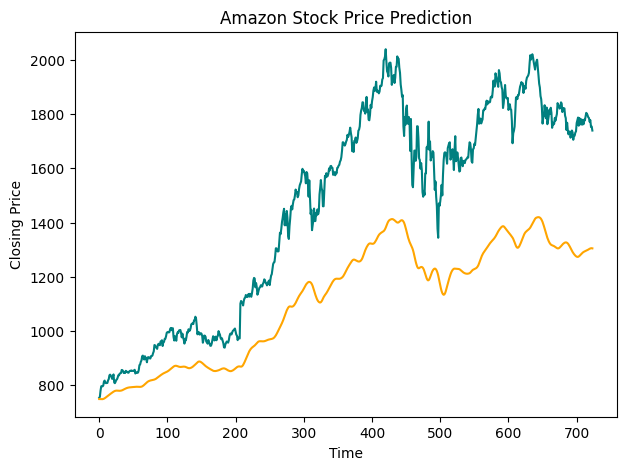

In [44]:
plt.figure(figsize=(7, 5))
plt.plot(test_set, color='teal')
plt.plot(preds, color='orange')
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

## Using Bidirectional LSTM and Time Distributed Layers



In [25]:
Model = Sequential()

# adding Bidirectional LSTM layers
Model.add(Bidirectional(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1))))
Model.add(Bidirectional(LSTM(units=128, activation='relu', return_sequences=True)))
Model.add(Dropout(0.2))  # Dropout layer to reduce overfitting

# adding Time Distributed layers for time series forcasting
Model.add(TimeDistributed(Dense(64, activation='relu')))
Model.add(TimeDistributed(Dense(1, activation='linear')))

# adding flattening layer
Model.add(tf.keras.layers.Flatten())

# adding dense layers
Model.add(Dense(units=128, activation='relu'))
Model.add(Dropout(0.2))  # Dropout layer to reduce overfitting
Model.add(Dense(units=64, activation='relu'))

Model.add(Dense(units=1, activation='linear'))
Model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
Model.fit(X_train, y_train, batch_size=32, epochs=20)

In [29]:
ds = pd.concat((df["Close"][:'2016'],df["Close"]['2017':]),axis=0)
inputs = ds[len(ds)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [30]:
X_test = []
for i in range(60,784):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
Pred = Model.predict(X_test)
Pred = scaler.inverse_transform(Pred)

23/23 [==============================] - 3s 117ms/step


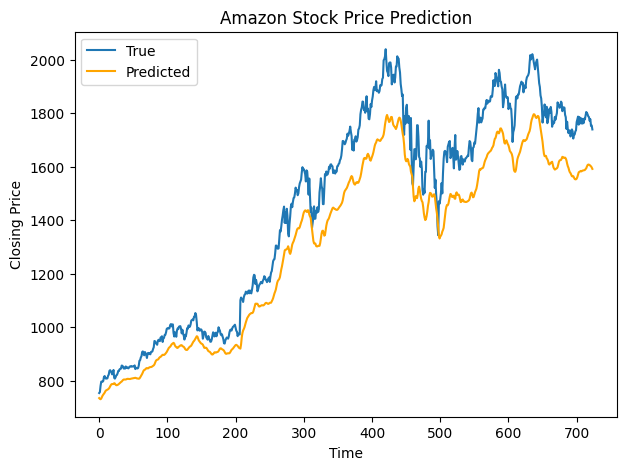

In [37]:
plt.figure(figsize=(7, 5))
plt.plot(test_set, label='True')
plt.plot(Pred, color='orange', label='Predicted')
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

## Comparing between Models

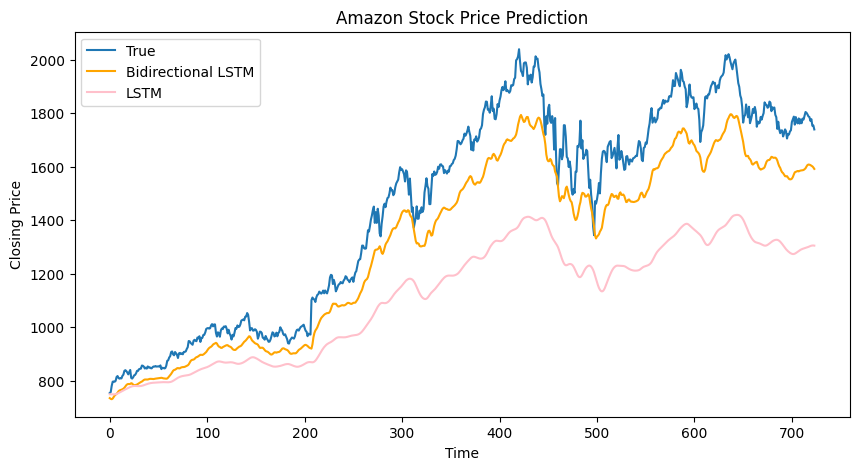

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(test_set, label='True')
plt.plot(Pred, color='orange', label='Bidirectional LSTM')
plt.plot(preds, color='pink', label='LSTM')
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

### It is clear that adding Bidirectional LSTM and Time Distributed Layers improves the performance of the RNN model